# SED error analysis

In this notebook we analyse the impact of errors in the SEDs over the generated PSFs. We study two kinds of degradations: the binning effect and the addition of noise over this bins. 


Some plots of this notebook run interactively using the `plotly` library. To select between static plots and interactive plots, modify the cell below.

In [1]:
interactive_plots = False
if interactive_plots:
    interactive = ''
else:
    interactive = 'svg'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import wf_psf

import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_psf_field as tf_psf_field

# Plot style & colormap

import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

from IPython.display import display, HTML

# Tables in python notebooks
from tabulate import tabulate

# Interactive plots
import plotly
import plotly.graph_objects as go
import plotly.io as pio   
pio.kaleido.scope.mathjax = None

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


plot_style = {
    'mpl_toolkits.legacy_colorbar': False,
    'axes.formatter.use_mathtext': True,
    'text.usetex': False,
}
mpl.rcParams.update(plot_style)

plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels

# Model Parameters

In [3]:
# Parameters
d_max = 2
max_order = 45
x_lims = [0, 1e3]
y_lims = [0, 1e3]
grid_points = [4, 4]
n_bins = 20
auto_init = True
verbose = True

oversampling_rate = 3.
output_Q = 3.

max_wfe_rms = 0.1
output_dim = 32
LP_filter_length = 2
euclid_obsc = True

pupil_diameter = 256

# Super resolved PSFs
super_out_Q = 1
super_out_res = 64

max_bins = 350

# Load Star SEDs

In [4]:
# SED folder path
SED_path = './../../../wf-psf/data/SEDs/save_SEDs/'
# Output saving path
output_folder = './../outputs/output-SEDs/'
plots_folder = './../outputs/plots/'

stellar_SEDs = np.load(SED_path + 'SEDs.npy', allow_pickle=True)
stellar_lambdas = np.load(SED_path + 'lambdas.npy', allow_pickle=True)
SED_name = ['O5V', 'B0V', 'B5-7V', 'A0V', 'A5V', 'F0V', 'F5V', 'G0V', 'G5V', 'K0V', 'K5V', 'M0V', 'M5V']
n_SEDs = len(SED_name)
# Create packed SEDs and lambdas lists
SED_list = []
for it in range(n_SEDs):
    concat_SED_wv = np.concatenate((stellar_lambdas.reshape(-1,1),
                                    stellar_SEDs[it,:].reshape(-1,1)), axis=1)
    SED_list.append(concat_SED_wv)
SED_np = np.array(SED_list)

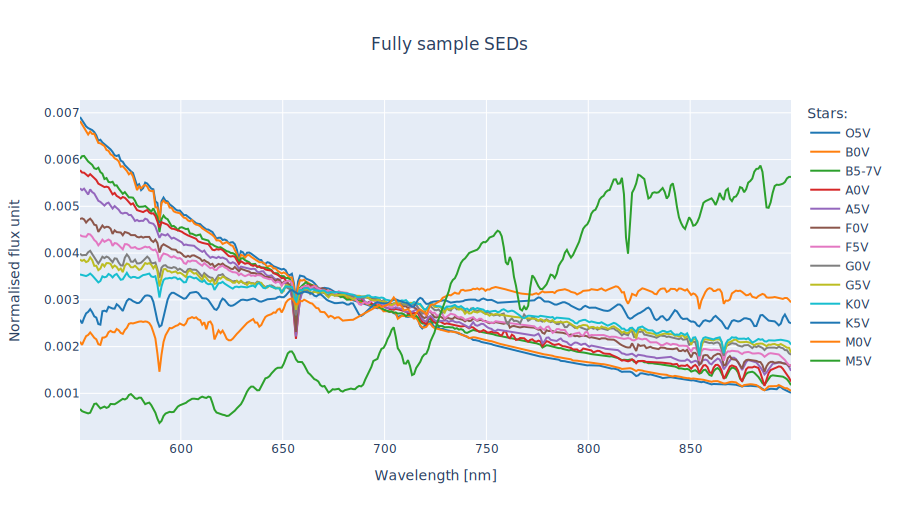

In [5]:
colors = plotly.colors.DEFAULT_PLOTLY_COLORS

fig = go.Figure()

for star_id in range(len(SED_name)):
    fig.add_trace(go.Scatter(
        x=stellar_lambdas,
        y=stellar_SEDs[star_id,:],
        name=SED_name[star_id],
        line=dict(color=colors[np.mod(star_id,10)])
    ))

fig.update_xaxes(title_text='Wavelength [nm]')
fig.update_yaxes(title_text="Normalised flux unit")
fig.update_layout(legend_title_text='Stars:', title={'text':'Fully sample SEDs', 'x':0.5}, width=900, height=520)

#fig.write_image('../outputs/plots/fully_sample_seds.pdf', engine='kaleido')
# Remove <'svg'> to run cell as an interactive plot
fig.show(interactive)

### Generate Zernikes and Initialize PSF generator

In [6]:
# Generate Zernike maps
zernikes = wf_psf.utils.zernike_generator(n_zernikes=max_order, wfe_dim=pupil_diameter)

# Initialize PSF simulator
sim_PSF_toolkit = wf_psf.SimPSFToolkit(
    zernikes, max_order=max_order, max_wfe_rms=max_wfe_rms, oversampling_rate=oversampling_rate,
    output_Q=super_out_Q, output_dim=super_out_res, pupil_diameter=pupil_diameter, euclid_obsc=euclid_obsc,
    LP_filter_length=LP_filter_length)

# Initialize PSF field
gen_poly_fieldPSF = wf_psf.GenPolyFieldPSF(sim_PSF_toolkit, d_max=d_max,
                                    grid_points=grid_points, max_order=max_order,
                                    x_lims=x_lims, y_lims=y_lims, n_bins=max_bins,
                                    lim_max_wfe_rms=max_wfe_rms, verbose=verbose)

In [7]:
# Load C_poly
C_poly = np.load('../outputs/ground_truth/C_poly.npy', allow_pickle=True)
gen_poly_fieldPSF.C_poly = C_poly

In [8]:
# Choose the location (randomly) and save it
# pos_np = np.random.rand(1, 2)
# pos_np[:,0] = pos_np[:,0]*(x_lims[1] - x_lims[0]) + x_lims[0]
# pos_np[:,1] = pos_np[:,1]*(y_lims[1] - y_lims[0]) + y_lims[0]
# np.save('../outputs/ground_truth/pos.npy',pos_np, allow_pickle=True)

# Load saved position
pos_np = np.load('../outputs/ground_truth/pos.npy', allow_pickle=True)

# Generate/load Ground Truth PSFs

In [9]:
generate_PSF = False

In [10]:
if generate_PSF:
    # Generate all the polychromatic PSFs
    gt_poly_psf_list = []
    zernike_coef_list = []

    # Generate polychromatic PSF at 3x Euclid resolution
    for it in range(n_SEDs):
        _psf, _zernike, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[0, 0],
                                                            yv_flat=pos_np[0, 1],
                                                            SED=SED_list[it])
        gt_poly_psf_list.append(_psf)
        zernike_coef_list.append(_zernike)  

    # Generate numpy arrays from the lists
    gt_poly_psf_np = np.array(gt_poly_psf_list)
    zernike_coef_np = np.array(zernike_coef_list)

    # Save ground truth data
    np.save('../outputs/ground_truth/gt_poly_psf.npy',gt_poly_psf_np,allow_pickle=True)
    np.save('../outputs/ground_truth/gt_zernike_coef.npy',zernike_coef_np,allow_pickle=True)
    np.save('../outputs/ground_truth/C_poly.npy',gen_poly_fieldPSF.C_poly,allow_pickle=True)

In [11]:
# Load data
gt_poly_psf_np = np.load('../outputs/ground_truth/gt_poly_psf.npy', allow_pickle=True)
zernike_coef_np = np.load('../outputs/ground_truth/gt_zernike_coef.npy', allow_pickle=True)


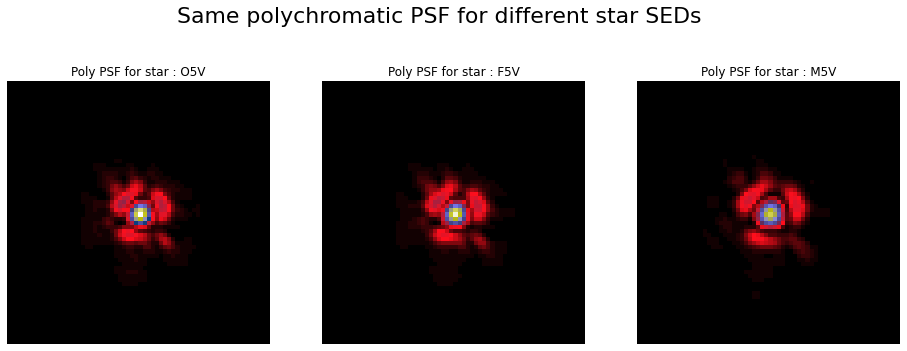

In [13]:
display_stars = [0, 6, 12]
vmax = np.max(np.abs(gt_poly_psf_np))

#fig, ax = plt.subplots(3, 5, figsize=(20,11), facecolor='white')
fig, ax = plt.subplots(1, 3, figsize=(16,6), facecolor='white')
fig.suptitle('Same polychromatic PSF for different star SEDs', fontsize=22)

# for itr, (axis,star_name) in enumerate(zip(ax.ravel(),SED_name)):
#     im = axis.imshow(gt_poly_psf_np[itr,:,:],cmap='gist_stern', vmax=vmax, vmin=0)
#     axis.set_title('Poly PSF for star : '+ star_name)
#     axis.set_xticks([])

for itr, star_id in enumerate(display_stars):
    im = ax[itr].imshow(gt_poly_psf_np[star_id,:,:],cmap='gist_stern', vmax=vmax, vmin=0)
    ax[itr].set_title('Poly PSF for star : '+ SED_name[star_id])
    ax[itr].set_xticks([])


for axis in ax.ravel():
    axis.axis('off')

#plt.savefig('../outputs/plots/PSF_for_each_SED.pdf')
plt.show()

In [14]:
# # Display all psf with interactive selector

# for psf_, star_name in zip(gt_poly_psf_list,SED_name):
#     fig = plt.figure(figsize=(5,5), facecolor='white')
#     plt.imshow(psf_,cmap='gist_stern', vmax=vmax, vmin=0)
#     plt.title('Poly PSF for star : '+ star_name)
#     plt.savefig(plots_folder+'poly_psf_'+star_name+'.jpg')
#     plt.close(fig)

# button_str = '<input type="radio" name="images" onclick="show{}();">{}</input>\n'
# image_str = '<div id="image{}">\n  <img src="./../outputs/plots/poly_psf_{}.jpg"\n  width="300"\n  height="300" >\n</div>\n'
# display_str = '  document.getElementById(\'image{}\').style.display =\'{}\';\n'

# html = 'Select an Image:\n'
# for it,star_name in enumerate(SED_name):
#     html = html + button_str.format(str(it+1), star_name)
# for it,star_name in enumerate(SED_name):
#     html = html + image_str.format(str(it+1), star_name)
# html = html + '<script>\n'

# for it,star_name in enumerate(SED_name):
#     html = html + 'function show{}(){{\n'.format(str(it+1))
#     for it_, star_name_ in enumerate(SED_name):
#         if it_ == it:
#             status = 'block'
#         else:
#             status = 'none'
#         html = html + display_str.format(it_+1, status)
#     html = html + '}\n'

# html = html + 'show1()\n</script>'

# display(HTML(html))


# Generate low SED resolution PSFs (binned SEDs)

In [15]:
generate_binned_PSF = False

In [16]:
n_bins_list = [4,8,16,32,64]
gen_poly_fieldPSF.sim_psf_toolkit.SED_sigma = 0

if generate_binned_PSF:
    # Generate all the polychromatic PSFs
    poly_psf_list = []

    for n_bins in n_bins_list:

        # Set right number of bins
        gen_poly_fieldPSF.n_bins = n_bins

        psf_list = []
        # Generate polychromatic PSF at 3x Euclid resolution
        for it in range(n_SEDs):
            _psf, _, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[0, 0],
                                                                yv_flat=pos_np[0, 1],
                                                                SED=SED_list[it])
            psf_list.append(_psf)

        poly_psf_list.append(psf_list)

    np.save('../outputs/predictions/binned_poly_psf.npy',np.array(poly_psf_list),allow_pickle=True)

In [17]:
# Load binned PSFs
binned_poly_psf =  np.load('../outputs/predictions/binned_poly_psf.npy',allow_pickle=True)

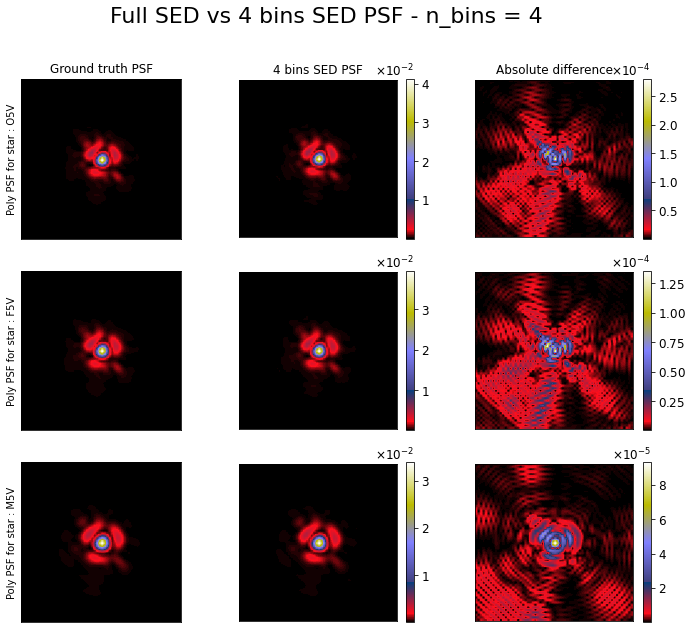

In [18]:
display_stars = [0, 6, 12]

fig, ax = plt.subplots(3, 3, figsize=(12,10), facecolor='white')
fig.suptitle('Full SED vs 4 bins SED PSF - n_bins = 4', fontsize=22)

for itr, star_id in enumerate(display_stars):
    im = ax[itr][0].imshow(gt_poly_psf_np[star_id,:,:],cmap='gist_stern')
    ax[itr][0].set_ylabel('Poly PSF for star : '+ SED_name[star_id])
    if itr == 0:
        ax[itr][0].set_title('Ground truth PSF')
    ax[itr][0].set_xticks([])
    ax[itr][0].set_yticks([])

    im = ax[itr][1].imshow(binned_poly_psf[0,star_id,:,:],cmap='gist_stern')
    if itr == 0:
        ax[itr][1].set_title('4 bins SED PSF')
    ax[itr][1].set_xticks([])
    ax[itr][1].set_yticks([])
    cbar = plt.colorbar(im, ax=ax[itr][1])
    cbar.formatter.set_powerlimits((0, 0))

    im = ax[itr][2].imshow(np.abs(gt_poly_psf_np[star_id,:,:]-binned_poly_psf[0,star_id,:,:]),cmap='gist_stern')
    if itr == 0:
        ax[itr][2].set_title('Absolute difference')
    ax[itr][2].set_xticks([])
    ax[itr][2].set_yticks([])
    cbar = plt.colorbar(im, ax=ax[itr][2])
    cbar.formatter.set_powerlimits((0, 0))

#plt.savefig('../outputs/plots/4bins_PSF_and_errors.pdf')
plt.show()

In [19]:
def get_RMSE(psf1, psf2):
    residual = np.sqrt(np.mean((psf1 - psf2)**2, axis=(0,1)))
    gt_mean  = np.sqrt(np.mean(psf1**2, axis=(0,1)))
    return residual, 100. * (residual/gt_mean)

In [20]:
abs_rmse_mat_binning = np.zeros((len(n_bins_list), len(SED_name)))
rel_rmse_mat_binning = np.zeros((len(n_bins_list), len(SED_name)))

for n_bins in range(len(n_bins_list)):
    for star_id in range(len(SED_name)):
        abs_rmse_mat_binning[n_bins, star_id], rel_rmse_mat_binning[n_bins, star_id] = get_RMSE(gt_poly_psf_np[star_id,:,:], binned_poly_psf[n_bins,star_id,:,:])

In [21]:
table = (np.around(rel_rmse_mat_binning, decimals=2)).tolist()

table.insert(0,SED_name.copy())
table[0].insert(0,'n_bins')
for idx, n_bins in enumerate(n_bins_list):
    table[idx+1].insert(0, n_bins)
print('\t\t\t\tRelative PSF error [%]')
print(tabulate(table))


				Relative PSF error [%]
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
n_bins  O5V   B0V   B5-7V  A0V   A5V   F0V   F5V   G0V   G5V   K0V   K5V   M0V   M5V
4       1.13  1.12  0.98   0.93  0.87  0.76  0.7   0.64  0.61  0.57  0.46  0.43  0.43
8       0.31  0.31  0.26   0.25  0.23  0.19  0.17  0.16  0.15  0.14  0.11  0.11  0.12
16      0.1   0.1   0.08   0.09  0.08  0.07  0.06  0.06  0.06  0.05  0.04  0.03  0.03
32      0.04  0.04  0.05   0.04  0.04  0.04  0.03  0.03  0.03  0.03  0.03  0.05  0.05
64      0.01  0.01  0.02   0.01  0.01  0.01  0.01  0.02  0.01  0.01  0.01  0.01  0.01
------  ----  ----  -----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----


# Generate noisy SED PSFs

In [22]:
generate_noisy_PSF = False
n_batch = 10

In [23]:
display_stars = [0, 6, 12]

n_bins_list = [4,8,16,32,64]
sigma_list = [0.1, 0.05, 0.02, 0.01, 0.005]

if generate_noisy_PSF:
    
    batch_noisy_poly_psf_list = []

    for batch_id in range(n_batch):
        # Generate all the polychromatic PSFs
        noisy_poly_psf_list = []

        # Generate PSFs for each number of bins
        for n_bins in n_bins_list:
            # Sigma values for the current n_bins SED. Adapt noise to the expected bin value (1/n_bins)
            sigma_vec = np.array(sigma_list)/n_bins

            # Set right number of bins
            gen_poly_fieldPSF.n_bins = n_bins

            psf_list = []
            # Generate every noise level PSF for each star type

            for star_id in display_stars:
                noisy_psf_list = []
                # Iterate over each noise level
                
                for SED_sigma in sigma_vec:
                    # Set noise std dev
                    gen_poly_fieldPSF.sim_psf_toolkit.SED_sigma = SED_sigma
                    # Generate PSF
                    _psf, _, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[0, 0],
                                                                        yv_flat=pos_np[0, 1],
                                                                        SED=SED_list[star_id])
                    noisy_psf_list.append(_psf)

                psf_list.append(noisy_psf_list)

            noisy_poly_psf_list.append(psf_list)

        batch_noisy_poly_psf_list.append(noisy_poly_psf_list)
        print('batch {}/{} done!'.format(batch_id+1, n_batch))


    # Convert to numpy and reorder axis so the noise sigma its the first axis (axis=0)
    noisy_poly_psf = np.moveaxis(np.array(batch_noisy_poly_psf_list),3,1)
    print(noisy_poly_psf.shape)
    #np.save('../outputs/predictions/noisy_poly_psf.npy', noisy_poly_psf, allow_pickle=True)

# Load numpy PSF array
noisy_poly_psf_np = np.load('../outputs/predictions/noisy_poly_psf.npy',allow_pickle=True)

### Noisy bins PSF vs binned PSF (just consider noise)

In [24]:
abs_rmse_mat_noisy = np.zeros((len(sigma_list), len(n_bins_list), len(SED_name)))
rel_rmse_mat_noisy = np.zeros((len(sigma_list), len(n_bins_list), len(SED_name)))

abs_rmse_batch_mat_noisy = np.zeros((n_batch, len(sigma_list), len(n_bins_list), len(SED_name)))
rel_rmse_batch_mat_noisy = np.zeros((n_batch, len(sigma_list), len(n_bins_list), len(SED_name)))


for itr, sigma in enumerate(sigma_list):

    for batch_id in range(n_batch):
        for n_bins in range(len(n_bins_list)):
            for star_itr, star_id in enumerate(display_stars):  
                    abs_rmse_batch_mat_noisy[batch_id,itr,n_bins, star_id], rel_rmse_batch_mat_noisy[batch_id,itr,n_bins, star_id] = get_RMSE(binned_poly_psf[n_bins,star_id,:,:], noisy_poly_psf_np[batch_id,itr,n_bins,star_itr,:,:])
    
    abs_rmse_mat_noisy = np.mean(abs_rmse_batch_mat_noisy, axis=0)
    rel_rmse_mat_noisy = np.mean(rel_rmse_batch_mat_noisy, axis=0)

    table = (np.around(rel_rmse_mat_noisy[itr,:,:], decimals=2)).tolist()

    table.insert(0,SED_name.copy())
    table[0].insert(0,'n_bins')
    for idx, n_bins in enumerate(n_bins_list):
        table[idx+1].insert(0, n_bins)
    print('\t\t\tRelative PSF error [%]  -  sigma = ', sigma)
    print(tabulate(table))
    print('\n\n')

			Relative PSF error [%]  -  sigma =  0.1
------  ----  ---  -----  ---  ---  ---  ----  ---  ---  ---  ---  ---  ----
n_bins  O5V   B0V  B5-7V  A0V  A5V  F0V  F5V   G0V  G5V  K0V  K5V  M0V  M5V
4       0.69  0.0  0.0    0.0  0.0  0.0  0.67  0.0  0.0  0.0  0.0  0.0  0.68
8       0.71  0.0  0.0    0.0  0.0  0.0  0.7   0.0  0.0  0.0  0.0  0.0  0.57
16      0.54  0.0  0.0    0.0  0.0  0.0  0.29  0.0  0.0  0.0  0.0  0.0  0.54
32      0.3   0.0  0.0    0.0  0.0  0.0  0.37  0.0  0.0  0.0  0.0  0.0  0.29
64      0.14  0.0  0.0    0.0  0.0  0.0  0.19  0.0  0.0  0.0  0.0  0.0  0.23
------  ----  ---  -----  ---  ---  ---  ----  ---  ---  ---  ---  ---  ----



			Relative PSF error [%]  -  sigma =  0.05
------  ----  ---  -----  ---  ---  ---  ----  ---  ---  ---  ---  ---  ----
n_bins  O5V   B0V  B5-7V  A0V  A5V  F0V  F5V   G0V  G5V  K0V  K5V  M0V  M5V
4       0.6   0.0  0.0    0.0  0.0  0.0  0.57  0.0  0.0  0.0  0.0  0.0  0.67
8       0.39  0.0  0.0    0.0  0.0  0.0  0.25  0.0  0.0  0.0  0.0

### Noisy bins PSF vs ground truth (binning and noise degradations)

In [25]:
abs_rmse_mat_noisy_bins = np.zeros((len(sigma_list), len(n_bins_list), len(SED_name)))
rel_rmse_mat_noisy_bins = np.zeros((len(sigma_list), len(n_bins_list), len(SED_name)))

abs_rmse_batch_mat_noisy_bins = np.zeros((n_batch, len(sigma_list), len(n_bins_list), len(SED_name)))
rel_rmse_batch_mat_noisy_bins = np.zeros((n_batch, len(sigma_list), len(n_bins_list), len(SED_name)))

for itr, sigma in enumerate(sigma_list):

    for batch_id in range(n_batch):
        for n_bins in range(len(n_bins_list)):
            for star_itr,star_id in enumerate(display_stars):
                abs_rmse_batch_mat_noisy_bins[batch_id,itr,n_bins, star_id], rel_rmse_batch_mat_noisy_bins[batch_id,itr,n_bins, star_id] = get_RMSE(gt_poly_psf_np[star_id,:,:], noisy_poly_psf_np[batch_id,itr,n_bins,star_itr,:,:])

    abs_rmse_mat_noisy_bins = np.mean(abs_rmse_batch_mat_noisy_bins, axis=0)
    rel_rmse_mat_noisy_bins = np.mean(rel_rmse_batch_mat_noisy_bins, axis=0)

    table = (np.around(rel_rmse_mat_noisy_bins[itr,:,:], decimals=2)).tolist()

    table.insert(0,SED_name.copy())
    table[0].insert(0,'n_bins')
    for idx, n_bins in enumerate(n_bins_list):
        table[idx+1].insert(0, n_bins)
    print('\t\t\tRelative PSF error [%]  -  sigma = ', sigma)
    print(tabulate(table))
    print('\n\n')

			Relative PSF error [%]  -  sigma =  0.1
------  ----  ---  -----  ---  ---  ---  ----  ---  ---  ---  ---  ---  ----
n_bins  O5V   B0V  B5-7V  A0V  A5V  F0V  F5V   G0V  G5V  K0V  K5V  M0V  M5V
4       1.37  0.0  0.0    0.0  0.0  0.0  0.96  0.0  0.0  0.0  0.0  0.0  0.88
8       0.83  0.0  0.0    0.0  0.0  0.0  0.72  0.0  0.0  0.0  0.0  0.0  0.59
16      0.55  0.0  0.0    0.0  0.0  0.0  0.3   0.0  0.0  0.0  0.0  0.0  0.54
32      0.3   0.0  0.0    0.0  0.0  0.0  0.38  0.0  0.0  0.0  0.0  0.0  0.29
64      0.14  0.0  0.0    0.0  0.0  0.0  0.19  0.0  0.0  0.0  0.0  0.0  0.23
------  ----  ---  -----  ---  ---  ---  ----  ---  ---  ---  ---  ---  ----



			Relative PSF error [%]  -  sigma =  0.05
------  ----  ---  -----  ---  ---  ---  ----  ---  ---  ---  ---  ---  ----
n_bins  O5V   B0V  B5-7V  A0V  A5V  F0V  F5V   G0V  G5V  K0V  K5V  M0V  M5V
4       1.14  0.0  0.0    0.0  0.0  0.0  0.93  0.0  0.0  0.0  0.0  0.0  0.76
8       0.49  0.0  0.0    0.0  0.0  0.0  0.33  0.0  0.0  0.0  0.0

# Plot results

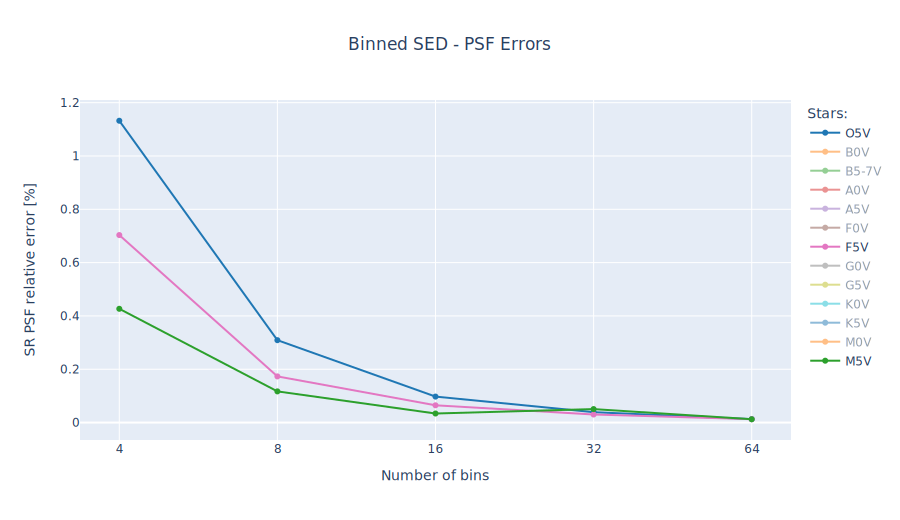

In [26]:
display_stars = [0,6,12]
colors = plotly.colors.DEFAULT_PLOTLY_COLORS

fig = go.Figure()

for star_id in range(len(SED_name)):
    fig.add_trace(go.Scatter(
        x=n_bins_list,
        y=rel_rmse_mat_binning[:,star_id],
        name=SED_name[star_id],
        visible=True if star_id in display_stars else 'legendonly',
        line=dict(color=colors[np.mod(star_id,10)])
    ))

fig.update_xaxes(tickvals=n_bins_list, title_text="Number of bins", type="log")
fig.update_yaxes(title_text="SR PSF relative error [%]")
fig.update_layout(legend_title_text='Stars:', title={'text':'Binned SED - PSF Errors', 'x':0.5}, width=900, height=520)

#fig.write_image('../outputs/plots/bins_errors.pdf', engine='kaleido')
fig.show(interactive)

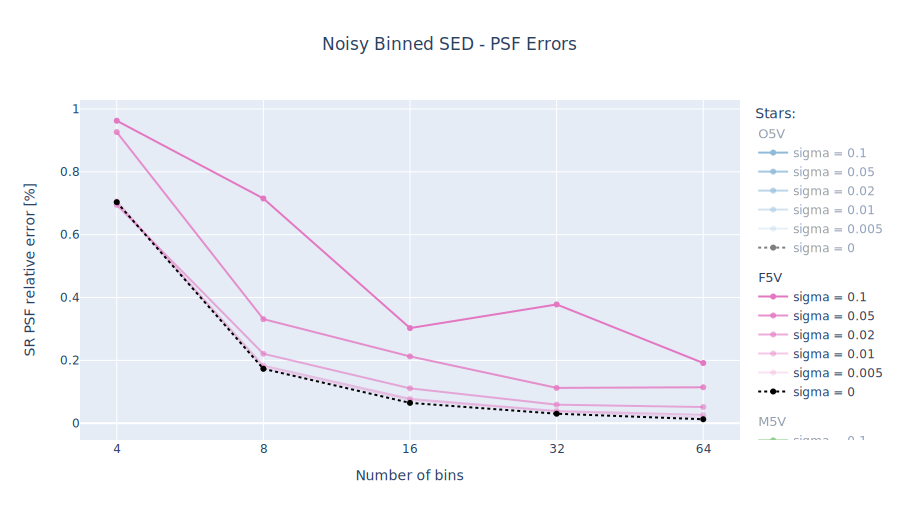

In [27]:
display_stars = [0,6,12]
star_init = 1
oppacity_sigma_list = [1, 0.8, 0.6, 0.4,0.2]

colors = plotly.colors.DEFAULT_PLOTLY_COLORS

fig = go.Figure()

for idx, star_id in enumerate(display_stars):
    for sigma_id in range(len(sigma_list)):
        fig.add_trace(go.Scatter(
            legendgroup=SED_name[star_id],
            legendgrouptitle_text=SED_name[star_id],
            x=n_bins_list,
            y=rel_rmse_mat_noisy_bins[sigma_id,:,star_id],
            name='sigma = {}'.format(sigma_list[sigma_id]),
            visible=True if idx==star_init else 'legendonly',
            line=dict(color='rgba'+colors[np.mod(star_id,10)][3:-1]+', {})'.format(oppacity_sigma_list[sigma_id]))
        ))
    # Sigma = 0, no Gaussian noise
    fig.add_trace(go.Scatter(
            legendgroup=SED_name[star_id],
            legendgrouptitle_text=SED_name[star_id],
            x=n_bins_list,
            y=rel_rmse_mat_binning[:,star_id],
            name='sigma = 0',
            visible=True if idx==star_init else 'legendonly',
            line=dict(color='black', dash='dot')
        ))

fig.update_xaxes(tickvals=n_bins_list, title_text="Number of bins", type="log")
fig.update_yaxes(title_text="SR PSF relative error [%]")
fig.update_layout(legend_title_text='Stars:', title={'text':'Noisy Binned SED - PSF Errors', 'x':0.5}, width=900, height=520)

#fig.write_image('../outputs/plots/noisy_bins_errors_M5V.pdf', engine='kaleido')
# Remove <'svg'> to run cell as an interactive plot
fig.show(interactive)

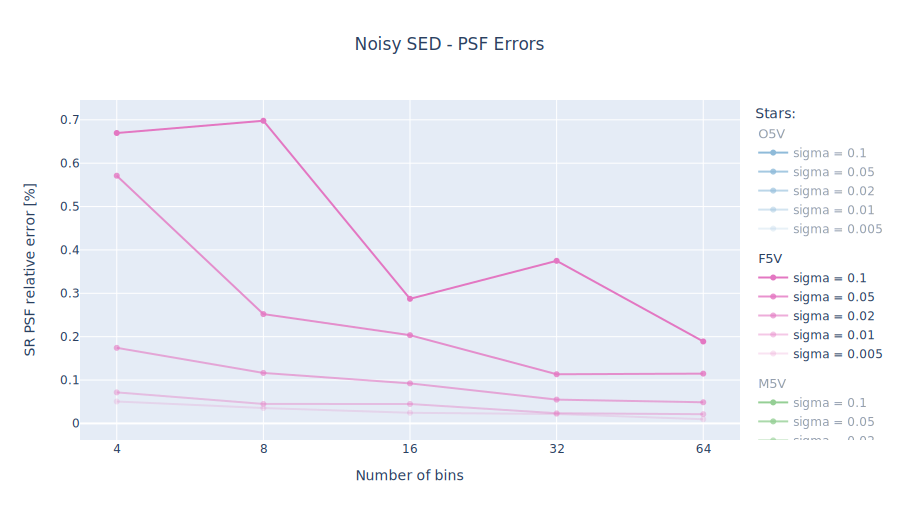

In [28]:
display_stars = [0,6,12]
star_init=1
oppacity_sigma_list = [1, 0.8, 0.6, 0.4,0.2]

colors = plotly.colors.DEFAULT_PLOTLY_COLORS

fig = go.Figure()

for idx, star_id in enumerate(display_stars):
    for sigma_id in range(len(sigma_list)):
        fig.add_trace(go.Scatter(
            legendgroup=SED_name[star_id],
            legendgrouptitle_text=SED_name[star_id],
            x=n_bins_list,
            y=rel_rmse_mat_noisy[sigma_id,:,star_id],
            name='sigma = {}'.format(sigma_list[sigma_id]),
            visible=True if idx==star_init else 'legendonly',
            line=dict(color='rgba'+colors[np.mod(star_id,10)][3:-1]+', {})'.format(oppacity_sigma_list[sigma_id])),
        ))

fig.update_xaxes(tickvals=n_bins_list, title_text="Number of bins", type="log")
fig.update_yaxes(title_text="SR PSF relative error [%]")
fig.update_layout(legend_title_text='Stars:', title={'text':'Noisy SED - PSF Errors', 'x':0.5}, width=900, height=520)

#fig.write_image('../outputs/plots/noisy_errors_M5V.pdf', engine='kaleido')
# Remove <'svg'> to run cell as an interactive plot
fig.show(interactive)

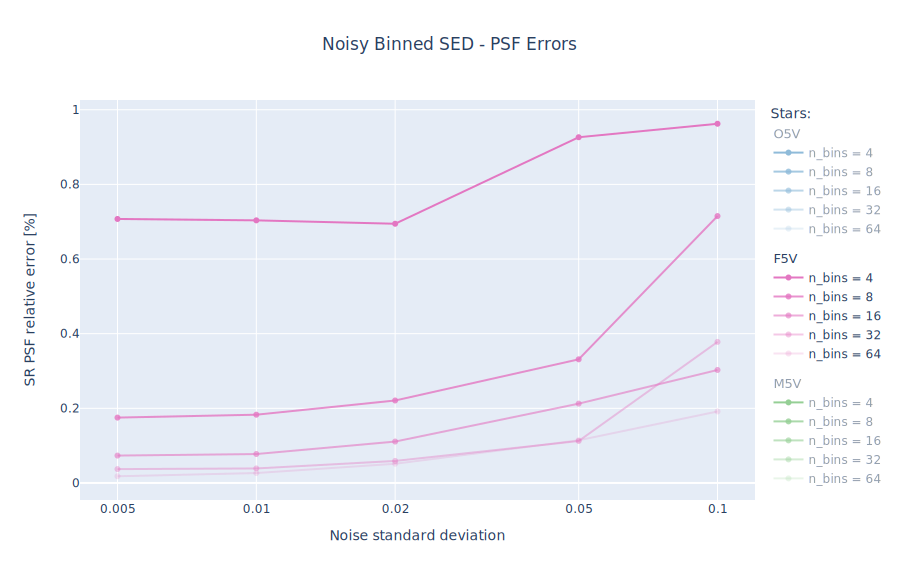

In [29]:
display_stars = [0,6,12]
oppacity_bins_list = [1, 0.8, 0.6, 0.4, 0.2]

colors = plotly.colors.DEFAULT_PLOTLY_COLORS

fig = go.Figure()

for idx, star_id in enumerate(display_stars):
    for bins_id in range(len(n_bins_list)):
        fig.add_trace(go.Scatter(
            legendgroup=SED_name[star_id],
            legendgrouptitle_text=SED_name[star_id],
            x=sigma_list,
            y=rel_rmse_mat_noisy_bins[:,bins_id,star_id],
            name='n_bins = {}'.format(n_bins_list[bins_id]),
            visible=True if idx==1 else 'legendonly',
            line=dict(color='rgba'+colors[np.mod(star_id,10)][3:-1]+', {})'.format(oppacity_bins_list[bins_id])),
        ))

fig.update_xaxes(tickvals=sigma_list, title_text="Noise standard deviation", type="log")
fig.update_yaxes(title_text="SR PSF relative error [%]")
fig.update_layout(legend_title_text='Stars:', title={'text':'Noisy Binned SED - PSF Errors', 'x':0.5}, width=900, height=580)

#fig.write_image('../outputs/plots/noisy_bins_errors_xsigma.pdf', engine='kaleido')
# Remove <'svg'> to run cell as an interactive plot
fig.show(interactive)

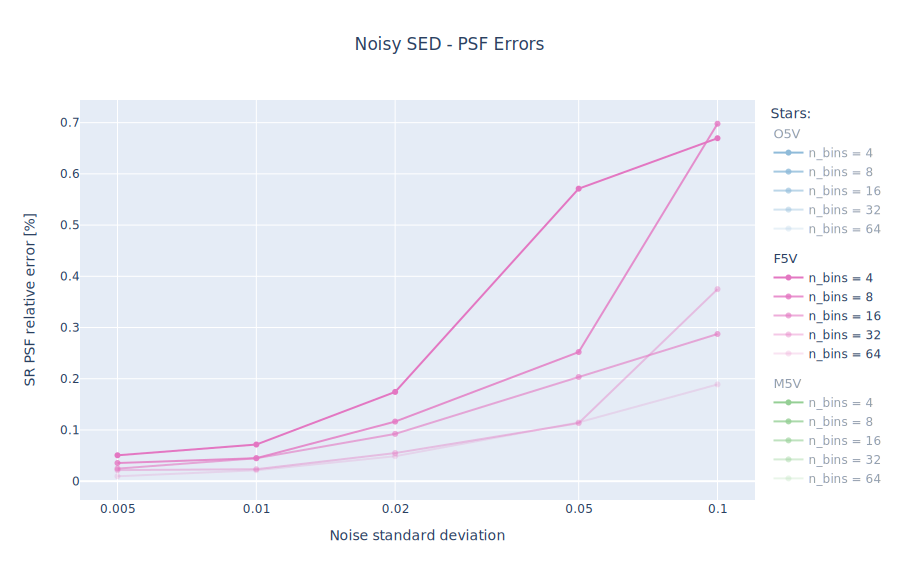

In [30]:
display_stars = [0,6,12]
oppacity_bins_list = [1, 0.8, 0.6, 0.4, 0.2]

colors = plotly.colors.DEFAULT_PLOTLY_COLORS

fig = go.Figure()

for idx, star_id in enumerate(display_stars):
    for bins_id in range(len(n_bins_list)):
        fig.add_trace(go.Scatter(
            legendgroup=SED_name[star_id],
            legendgrouptitle_text=SED_name[star_id],
            x=sigma_list,
            y=rel_rmse_mat_noisy[:,bins_id,star_id],
            name='n_bins = {}'.format(n_bins_list[bins_id]),
            visible=True if idx==1 else 'legendonly',
            line=dict(color='rgba'+colors[np.mod(star_id,10)][3:-1]+', {})'.format(oppacity_bins_list[bins_id])),
        ))

fig.update_xaxes(tickvals=sigma_list, title_text="Noise standard deviation", type="log")
fig.update_yaxes(title_text="SR PSF relative error [%]")
fig.update_layout(legend_title_text='Stars:', title={'text':'Noisy SED - PSF Errors', 'x':0.5}, width=900, height=580)

#fig.write_image('../outputs/plots/noisy_errors_xsigma.pdf', engine='kaleido')
# Remove <'svg'> to run cell as an interactive plot
fig.show(interactive)